In [1]:
#Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.experimental.preprocessing import Normalization
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

In [2]:
#Read the data LCDM & MoG
PS = '_TEcls'
label = '_FR0_e-1_FRn'
planck_df_LCDM = np.genfromtxt('./data/tecls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_df_MoG = np.genfromtxt('./data/tecls_MoGRIDS_NOISY%s.csv'%label, delimiter=',')
planck_cls_LCDM = planck_df_LCDM[1:] # get rid of the first column, i.e. multipole moment l
planck_cls_MoG = planck_df_MoG[1:]
ls = planck_df_LCDM[0]
#Add the model class: 
LCDM_class = np.zeros(len(planck_cls_LCDM))
MoG_class = np.ones(len(planck_cls_MoG))
#The full arrays (+target):
cls_LCDM_class = np.column_stack((planck_cls_LCDM, LCDM_class))
cls_MoG_class = np.column_stack((planck_cls_MoG, MoG_class))

#Full data set
cls_full_dataset = np.concatenate((planck_cls_LCDM, planck_cls_MoG)) #without the class: x_dataset
dataset_class = np.concatenate((LCDM_class, MoG_class)) #only the class: y_dataset
cls_full_dataset_class = np.concatenate((cls_LCDM_class, cls_MoG_class)) #with the class: xy_dataset

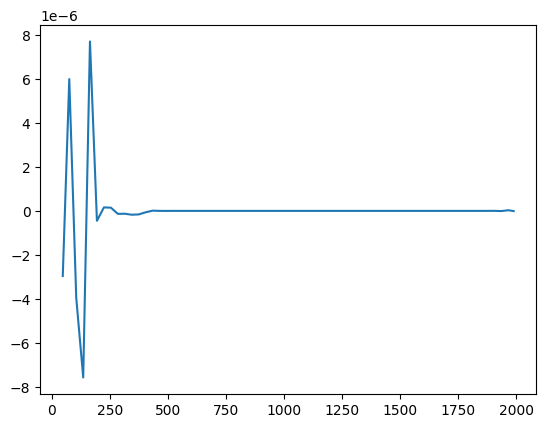

In [3]:
plt.plot(ls,planck_cls_LCDM[0]-planck_cls_MoG[0])

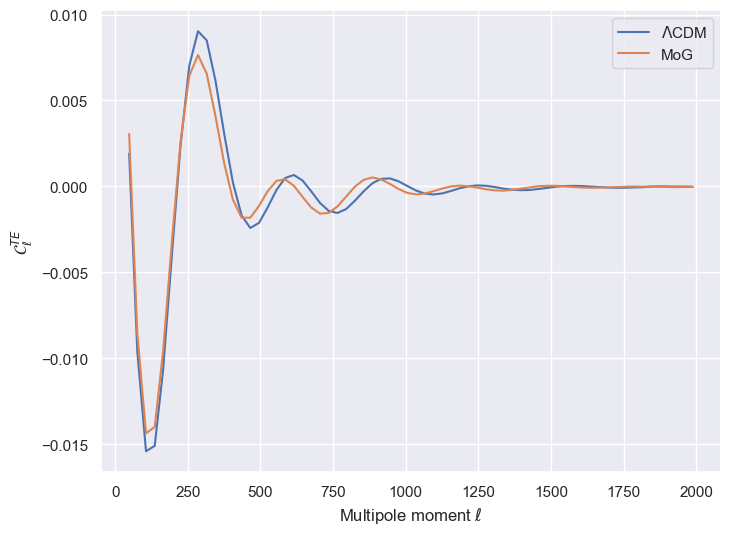

In [4]:
#-----------------------------------------------------------------------------------------------------------------------
#Without normalization
#-----------------------------------------------------------------------------------------------------------------------
import seaborn as sns
sns.set_theme() # Apply the default theme for seaborn

fig = plt.figure(figsize=(8,6))
plt.plot(ls,cls_full_dataset[:1000][0], label='$\Lambda$CDM')
plt.plot(ls,cls_full_dataset[1000:][999], label='MoG')
plt.xlabel('Multipole moment ${\ell}$')
plt.ylabel('$\mathcal{C}^{TE}_{\ell}$')
plt.legend()
#plt.grid(color='lightgray', linestyle='--')
#fig.savefig('./figures/DimLessCls.pdf')

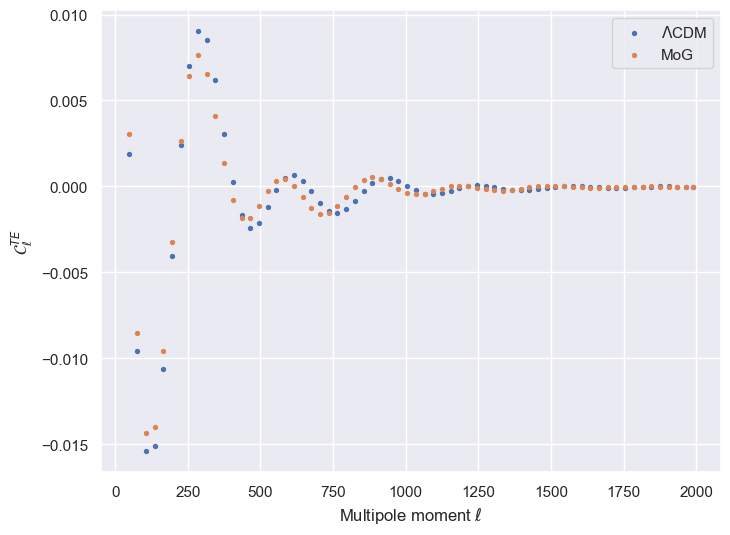

In [34]:
#-----------------------------------------------------------------------------------------------------------------------
#Without normalization
#-----------------------------------------------------------------------------------------------------------------------
import seaborn as sns
sns.set_theme() # Apply the default theme for seaborn

fig = plt.figure(figsize=(8,6))
plt.scatter(ls,cls_full_dataset[:1000][0], label='$\Lambda$CDM', marker='o', s=8)
plt.scatter(ls,cls_full_dataset[1000:][999], label='MoG', marker='o', s=8)
plt.xlabel('Multipole moment ${\ell}$')
plt.ylabel('$\mathcal{C}^{TE}_{\ell}$')
plt.legend()
#plt.grid(color='lightgray', linestyle='--')
fig.savefig('./figures%s/DimLessCls1.pdf'%PS)

In [6]:
# Create a function for converting the c_ls^TT to Dl's
import math
def Dls(l,CTT):
    Dl = [l[i]*(l[i]+1)*CTT[i]/((2*math.pi)*(2.7255*10**6)**2) for i in range(len(l))]
    return Dl

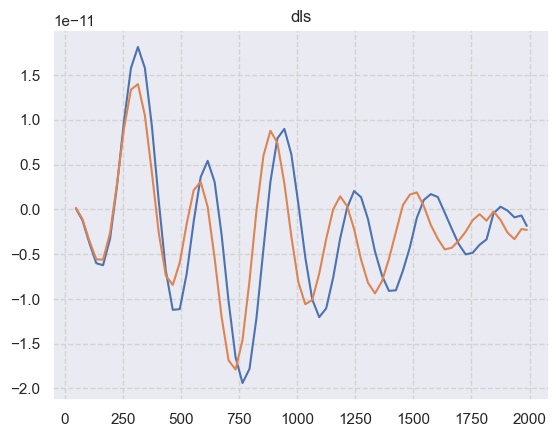

In [7]:
#Dls plot: LCDM & MoG examples
plt.plot(ls,Dls(ls,cls_full_dataset[:1000][0]))
plt.plot(ls,Dls(ls,cls_full_dataset[1000:][999]))
plt.title('dls')
plt.grid(color='lightgray', linestyle='--')

Text(0, 0.5, 'Normalized $\\mathcal{C}^{TE}_{\\ell}$')

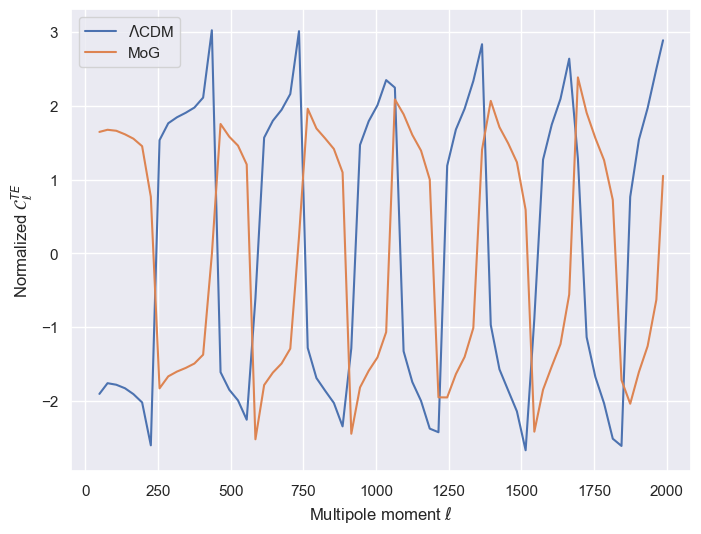

In [8]:
#-------------------------------------------------------------------------------------------------------------
#First approach: Data preprosessing outside the architecture
#-------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)
plt.plot(ls,normalized_data[0], label='$\Lambda$CDM')
plt.plot(ls,normalized_data[-1], label='MoG')
#plt.grid(color='lightgray', linestyle='--')
plt.legend()
plt.xlabel('Multipole moment ${\ell}$')
plt.ylabel('Normalized $\mathcal{C}^{TE}_{\ell}$')
#fig.savefig('./figures/Normalized_DimLess_Cls.pdf')

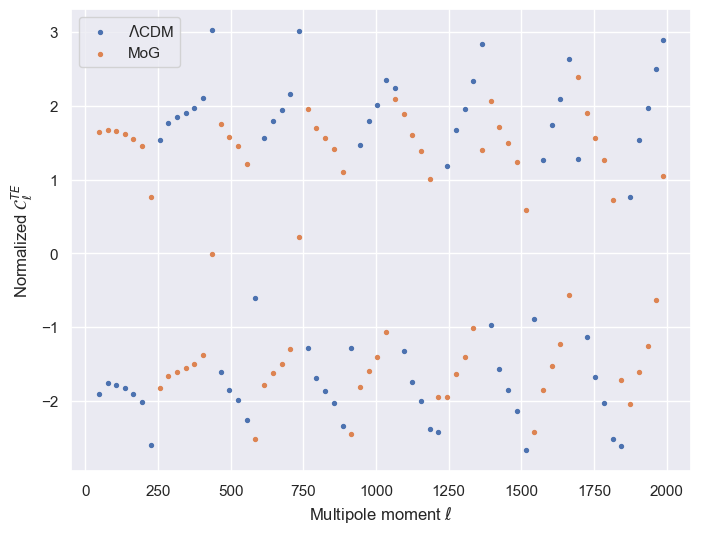

In [33]:
#-------------------------------------------------------------------------------------------------------------
#First approach: Data preprosessing outside the architecture
#-------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)
plt.scatter(ls,normalized_data[0], label='$\Lambda$CDM', marker='o', s=8)
plt.scatter(ls,normalized_data[-1], label='MoG', marker='o', s=8)
#plt.grid(color='lightgray', linestyle='--')
plt.legend()
plt.xlabel('Multipole moment ${\ell}$')
plt.ylabel('Normalized $\mathcal{C}^{TE}_{\ell}$')
fig.savefig('./figures%s/Normalized_DimLess_Cls1.pdf' %PS)

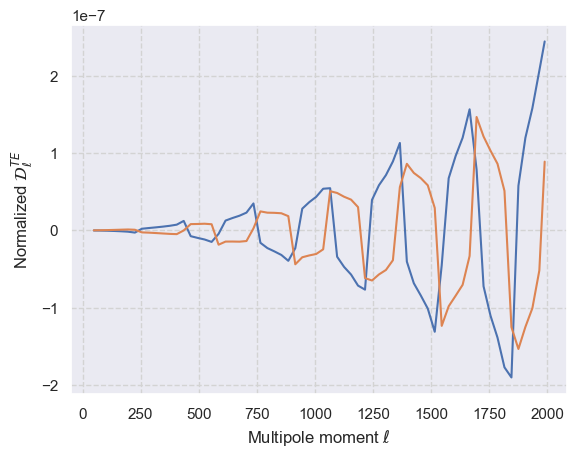

In [10]:
#Dls plot: LCDM & MoG NORMALIZED examples
plt.plot(ls,Dls(ls,normalized_data[0]))
plt.plot(ls,Dls(ls,normalized_data[-1]))
plt.xlabel('Multipole moment ${\ell}$')
plt.ylabel('Normalized $\mathcal{D}^{TE}_{\ell}$')
plt.grid(color='lightgray', linestyle='--')

In [11]:
print('var: %.4f' % np.var(normalized_data))
print('mean: %.4f' % np.mean(normalized_data))
#Z-SCORE NORMALIZATION

var: 1.0000
mean: 0.0000


In [12]:
#Train_test_split
from sklearn.model_selection import train_test_split
normalized_data_numpy = normalized_data.numpy()

In [13]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(normalized_data_numpy, dataset_class, test_size=0.3, random_state=42)
# Split the data into training and validation sets with fixed random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
#Redefine the model's architecture to display the input layer: (functional API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Define input layer
inputs = Input(shape=(len(normalized_data[0]),), name='input_layer') #shape=X_train.shape[1],

# Define hidden layers
hidden_layer = Dense(32, activation='relu', name='hidden_layer')(inputs)
dropout_layer = Dropout(rate=0.2, name='dropout_layer')(hidden_layer)

# Define output layer
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout_layer)

# Create the model
model = Model(inputs=inputs, outputs=outputs, name='Angular_PS_NN')

# Display model summary
model.summary()

Model: "Angular_PS_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 66)]              0         
                                                                 
 hidden_layer (Dense)        (None, 32)                2144      
                                                                 
 dropout_layer (Dropout)     (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2177 (8.50 KB)
Trainable params: 2177 (8.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.reset_states()

In [16]:
#Compile model:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

#Training attempt:
History = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/1000
35/35 [==============================] - 1s 11ms/step - loss: 0.8381 - accuracy: 0.4991 - val_loss: 0.7479 - val_accuracy: 0.4643
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7624 - accuracy: 0.4911 - val_loss: 0.7063 - val_accuracy: 0.4571
Epoch 3/1000
35/35 [==============================] - 0s 7ms/step - loss: 0.7425 - accuracy: 0.4696 - val_loss: 0.7021 - val_accuracy: 0.4679
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7108 - accuracy: 0.5446 - val_loss: 0.7022 - val_accuracy: 0.4429
Epoch 5/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7174 - accuracy: 0.5402 - val_loss: 0.7019 - val_accuracy: 0.4357
Epoch 6/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.5286 - val_loss: 0.7001 - val_accuracy: 0.4286
Epoch 7/1000
35/35 [==============================] - 0s 5ms/step - loss: 0.7075 - accuracy: 0.5312 - val_loss: 0.7005 - val_accuracy: 0.4643
Epoch

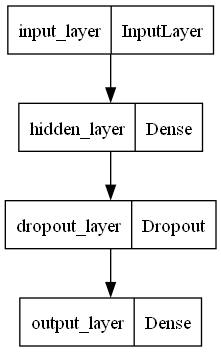

In [17]:
from tensorflow.keras.utils import plot_model
import pydot
#for this to work pip install pydot
#install graphviz.exe for windows: https://graphviz.gitlab.io/download/

plot_model(model, to_file='./figures%s/model_plot.png' %PS, show_shapes=False, show_layer_names=True, show_dtype=False, rankdir='TB', expand_nested=True, dpi=96, layer_range=None)

In [18]:
#Save the model:
model.save('./figures%s/Planck_NN_model.h5' %PS)

c:\Users\indi_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import netron

netron.start('./figures%s/Planck_NN_model.h5' %PS)

Serving './figures_TEcls/Planck_NN_model.h5' at http://localhost:8080


('localhost', 8080)

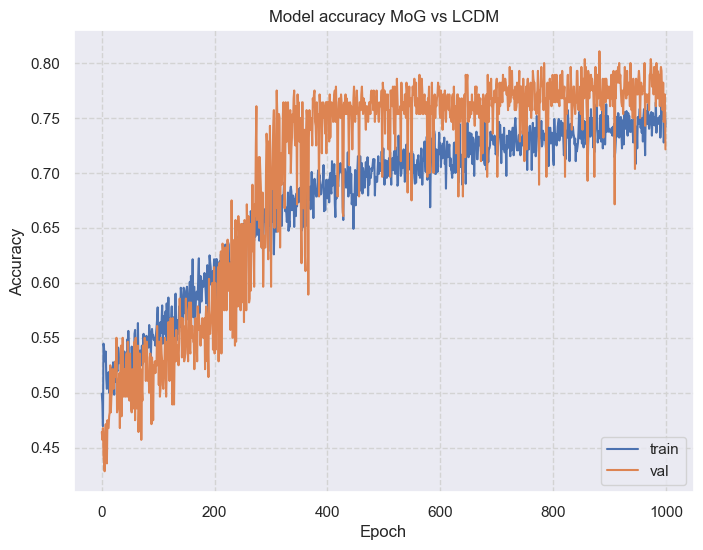

In [20]:
fig = plt.figure(figsize=(8,6))
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy MoG vs LCDM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.grid(color='lightgray', linestyle='--')
plt.show()
fig.savefig('./figures%s/Accuracy_Planck_NN%s_TE.png' %(PS,label))

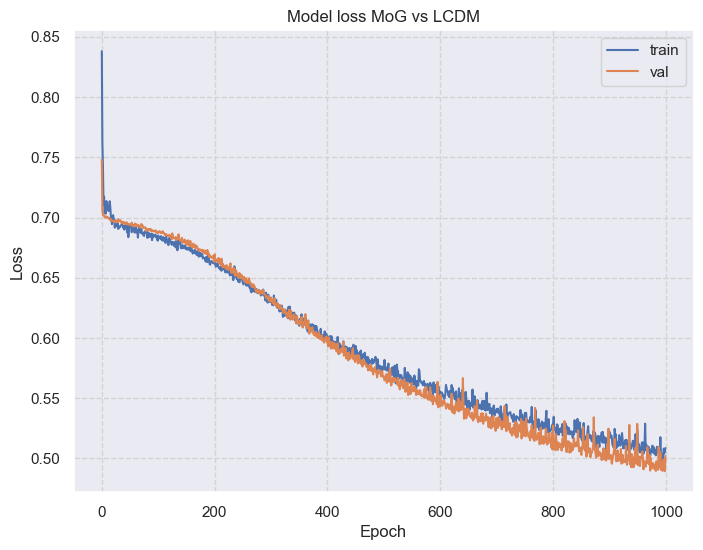

In [21]:
fig = plt.figure(figsize=(8,6))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss MoG vs LCDM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(color='lightgray', linestyle='--')
plt.show()
fig.savefig('./figures%s/Loss_Planck_NN%s_TE.png' %(PS,label))

In [22]:
#Round probability of classification
def normMoG(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Round probability of classification
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [23]:
#Test the NN
theory = ['LCDM','HS']
# X_train, X_test, y_train, y_test

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(X_test)):
  X_test_tf = tf.convert_to_tensor([X_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normMoG(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))
#For the testing procedure, when defining the NN, I manually set the shape to (,83)->[1, 2, 3, ..., 83]
#but I needed to convert manually the X_test array to (1,83)->[[1, 2, 3, ..., 83]]

1/1 [==============================] - 0s 38ms/step


In [24]:
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]
print(lenghts)

[240, 216, 82, 62]


In [25]:
print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.4 0.36
False 0.13666666666666666 0.10333333333333333
--------------
Correct prediction:  0.76
Wrong prediction  :  0.24


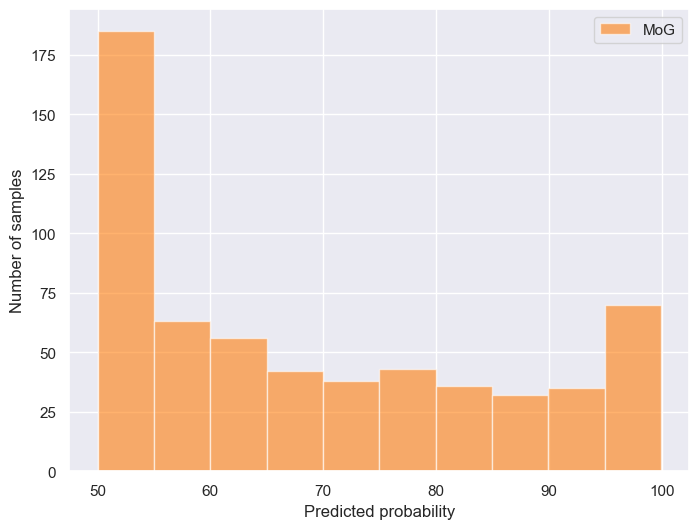

In [26]:
fig = plt.figure(figsize=(8,6))
plt.hist(prob_pred_MoG, label='MoG', alpha=0.6, color='#FF7F0E')
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.legend()
plt.show()
fig.savefig('./figures%s/Hist_MoG_TE%s.png'%(PS,label))

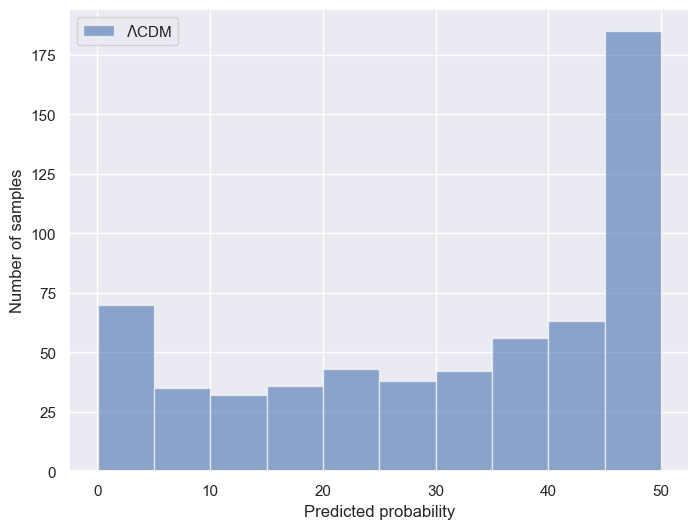

In [27]:
fig = plt.figure(figsize=(8,6))
plt.hist(prob_pred_LCDM, label='$\Lambda$CDM', alpha=0.6)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.legend()
plt.show()
fig.savefig('./figures%s/Hist_LCDM_TE%s.png'%(PS,label))

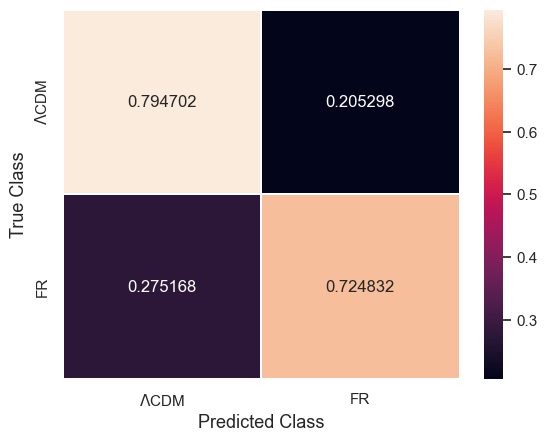

In [28]:
#Confusion matrix
from sklearn import metrics
import seaborn as sns

cm = metrics.confusion_matrix(true_model, pred_model)

#Create normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, 
            annot=True, linewidths=0.01,
            fmt='g', 
            xticklabels=['$\Lambda$CDM', 'FR'],
            yticklabels=['$\Lambda$CDM', 'FR'])
plt.xlabel('Predicted Class',fontsize=13)
plt.ylabel('True Class',fontsize=13)
#plt.title('Confusion Matrix',fontsize=17)
plt.savefig('./figures%s/conf_matrix%s_TE.png' %(PS,label))
plt.show()

Text(0, 0.5, 'Performance')

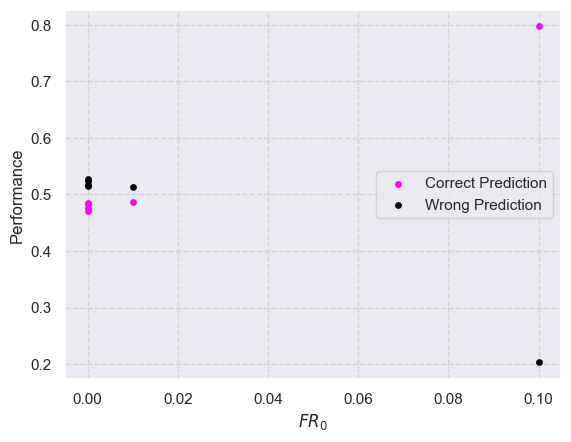

In [29]:
FR0_fid=5.e-6
FR0=np.array([1.e-1, 1.e-2, 1.e-5, 1.e-6, 1.e-7, 1.e-8])
Corr_pred = np.array([0.797, 0.486, 0.485, 0.483, 0.476, 0.471])
Wrong_pred = np.array([0.203, 0.514, 0.515, 0.516, 0.523, 0.528])
plt.scatter(FR0, Corr_pred, s=15, color='magenta', label='Correct Prediction')
plt.scatter(FR0, Wrong_pred, s=15, color='black', label='Wrong Prediction')
plt.axvspan(FR0_fid-5.e-7, FR0_fid+5.e-7, color='yellow', alpha=0.5, lw=0)
plt.grid(color='lightgray', linestyle='--')
plt.legend()
plt.xlabel('$FR_0$')
plt.ylabel('Performance')

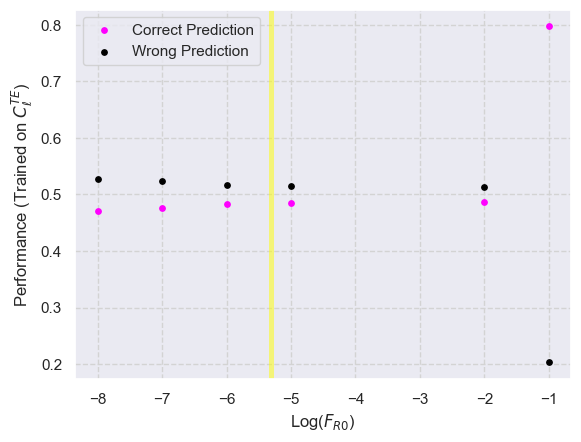

In [35]:
plt.scatter(np.log10(FR0), Corr_pred, s=15, color='magenta', label='Correct Prediction')
plt.scatter(np.log10(FR0), Wrong_pred, s=15, color='black', label='Wrong Prediction')
plt.legend()
plt.grid(color='lightgray', linestyle='--')
plt.axvspan(np.log10(FR0_fid-5.e-7), np.log10(FR0_fid+5.e-7), color='yellow', alpha=0.5, lw=0)
plt.xlabel('Log($F_{R0}$)')
plt.ylabel('Performance (Trained on $C^{TE}_{\ell}$)')
plt.savefig('./figures/FR0_values%s.pdf' %PS)